In [1]:
import test_config as cfg
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import os, os.path
import pickle
import io

import skimage
import skimage.io, skimage.transform, skimage.filters
import scipy.ndimage

import sys
sys.path.append(r'../src/')

import importlib
import transform
import filters
import local_radon
import skew_line
importlib.reload(transform)
importlib.reload(filters)
importlib.reload(local_radon)
importlib.reload(skew_line)

<module 'skew_line' from '../src\\skew_line.py'>

D:/Data/bujo_sample\20190309_125151.jpg


C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Anaconda3\lib\site-packages\skimage\transform\radon_transform.py:69: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


Text angles is 0.0
Text line delta is 9
Wall time: 1.02 s


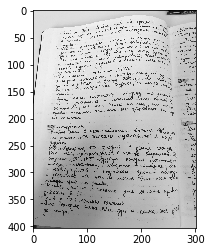

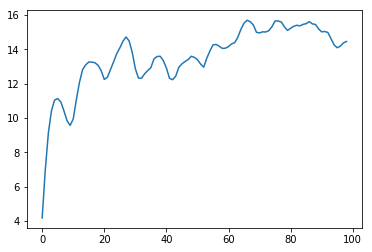

In [2]:
%%time
src_fname = os.path.join(cfg.sample_path, os.listdir(cfg.sample_path)[6])
print(src_fname)
src = skimage.io.imread(src_fname, as_grey=True)

src2 = skimage.transform.rescale(src, scale=0.05)

text_angle = transform.get_text_angle(src2)
print('Text angles is {}'.format(text_angle[0][0]))

src3 = skimage.transform.rotate(skimage.transform.rescale(src, scale=0.1), -90.0-text_angle[0][0], resize=True)
plt.figure()
plt.imshow(src3, cmap='gray')

text_line_delta, text_line_deltas = transform.get_text_line_delta(src3)
plt.figure()
plt.plot(text_line_deltas)
print('Text line delta is {}'.format(text_line_delta))

C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[(-1.5466302294595904, -64.0, 0, 162, 1677)]
Wall time: 151 ms


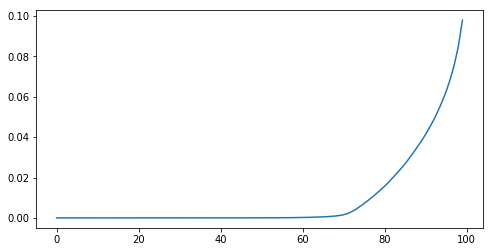

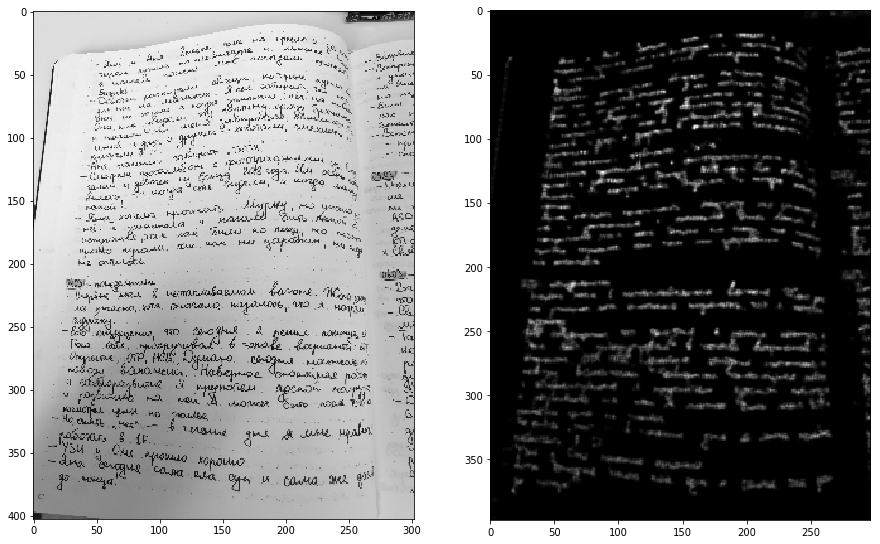

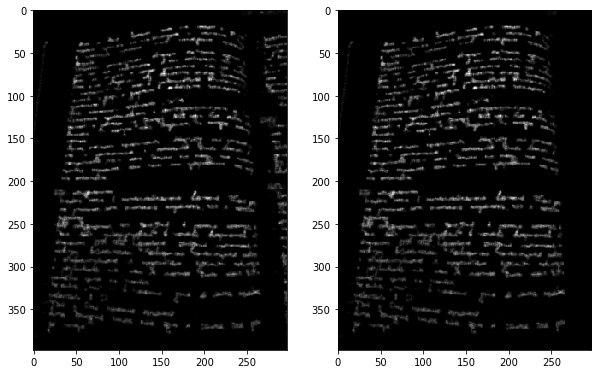

In [3]:
%%time
src4 = transform.filter_variance(src3, (text_line_delta//2, text_line_delta//2), 50, 50)
text_cutoff = np.percentile(src4, 90)/2

src5 = skimage.transform.rescale(src4>text_cutoff, scale=0.25)>0.0
src6 = skimage.filters.gaussian(src5, sigma=0.2)>0.4

vsplits = transform.search_region_vsplit(src6, np.pi*3/8, num_angles=131,
                                         window_size_1d=15, max_value=2, zero_threshold=10,
                                         min_split_abs=100, max_split_pct=0.10)

src7 = transform.erase_regions(src4, vsplits, dsz=4)


plt.figure(figsize=(8,4))
plt.plot(np.percentile(src4, range(100)))

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(src3, cmap='gray')
plt.subplot(122)
plt.imshow(src4, cmap='gray')

print(vsplits)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(src4, cmap='gray')
plt.subplot(122)
plt.imshow(src7, cmap='gray')

Wall time: 1.06 s


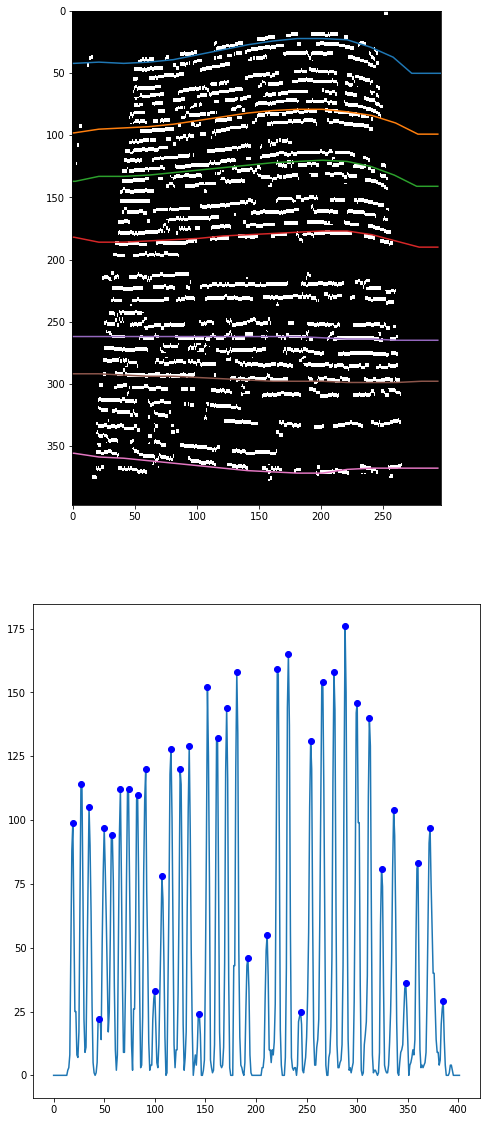

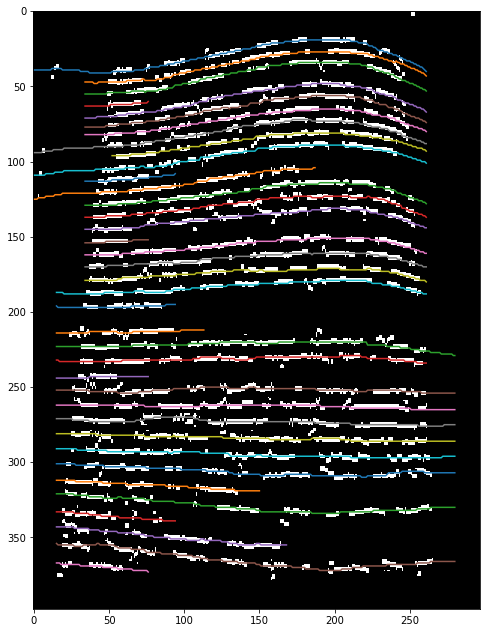

In [4]:
%%time
src8 = filters.local_maxima_v(src7, 1, text_line_delta//2, text_cutoff)*1.0

curves = skew_line.create_support_curves(src8, 20, (40, 50))

ires, imeta = skew_line.integrate_curves(src8, curves)
ids = skew_line.select_line_candidates(ires, text_line_delta//2, min_value=20, minmax_ratio=0.8)

all_curves = []
for i in ids:
    if len(imeta[i])>2:
        tmp_j, tmp_i = skew_line.interpolate_between_curves(np.arange(src8.shape[1]), 0, src8.shape[0]-1, imeta[i][0], imeta[i][1], imeta[i][2])
    else:
        tmp_j, tmp_i = skew_line.offset_curve(np.arange(src8.shape[1]), imeta[i][0], imeta[i][1])
    res_j, res_i = skew_line.optimize_curve(src8, tmp_j, tmp_i, offset=4, min_window=20)
    all_curves.append((res_j, res_i))

plt.figure(figsize=(8,20))
plt.subplot(211)
plt.imshow(src8, cmap='gray')
for crv in curves:
    plt.plot(crv[:,1], crv[:,0])
    
plt.subplot(212)
plt.plot(ires)
for i in ids:
    plt.plot(i, ires[i], 'bo')
    
plt.figure(figsize=(8,20))
plt.imshow(src8, cmap='gray')
for crv_j, crv_i in all_curves:
    plt.plot(crv_j, crv_i)

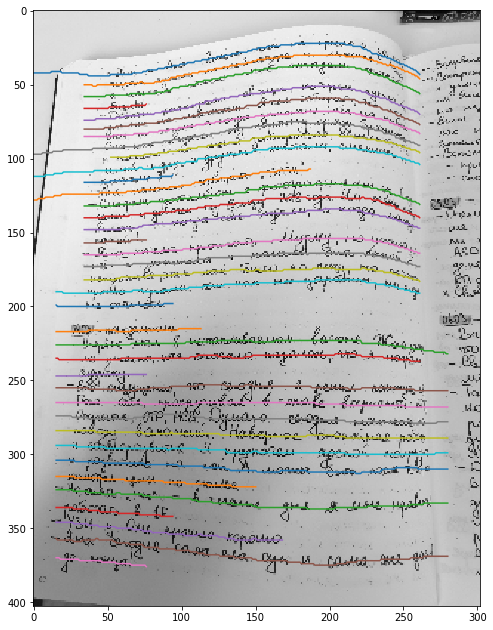

In [14]:
plt.figure(figsize=(8,20))
plt.imshow(src3, cmap='gray')
for crv_j, crv_i in all_curves:
    plt.plot(crv_j, crv_i+3)

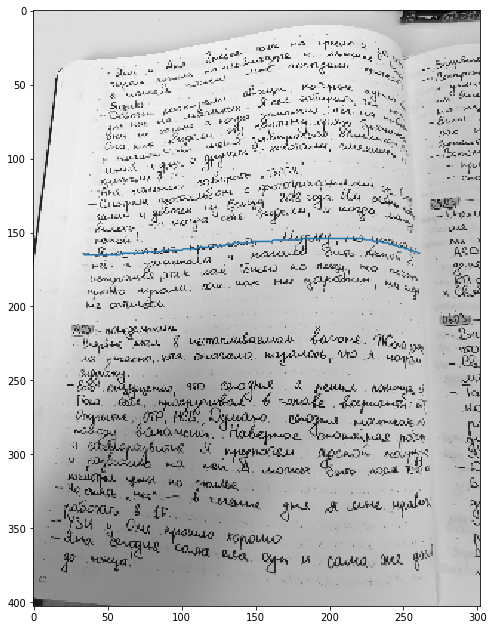

In [99]:
tst_curve = all_curves[16]
plt.figure(figsize=(8,20))
plt.imshow(src3, cmap='gray')
plt.plot(tst_curve[0], tst_curve[1]+3)

array([ 1.25366468,  1.91187793,  1.65059112,  0.70044231,  0.22607832,
        0.18515266,  0.35596493,  1.00681309,  3.71682267,  8.58532508,
       10.45285769,  7.53688636,  3.57943998,  1.05823352,  0.62610021,
        0.71627584,  1.18795763,  3.16106923,  7.15129742,  9.72455424,
        8.66901352])

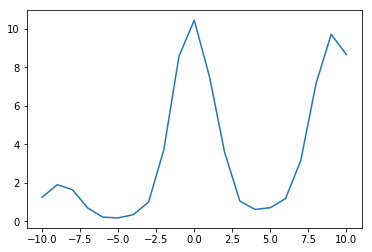

In [100]:
# test on variance-filtered
offsets = np.arange(-10, 11)
res = np.array([np.sum(src4[tst_curve[1]+off, tst_curve[0]]) for off in offsets])
plt.plot(offsets, res)
res

array([176.3151111 , 172.58622181, 173.22294526, 178.53361657,
       180.20869417, 179.11213826, 177.08381543, 173.51825885,
       156.69480925, 146.62288619, 138.82244471, 144.20016242,
       169.69111067, 171.24515435, 173.96327555, 174.60906922,
       172.28529827, 159.81928917, 143.98610053, 141.24355116,
       145.43753463])

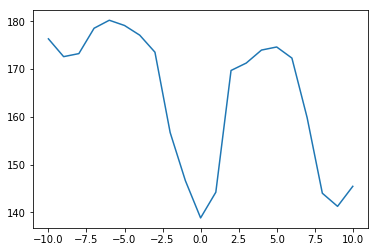

In [101]:
# test on source
offsets = np.arange(-10, 11)
res = np.array([np.sum(src3[tst_curve[1]+off+3, tst_curve[0]]) for off in offsets])
plt.plot(offsets, res)
res

In [36]:
srcr = skimage.transform.rotate(src, -90.0-text_angle[0][0], resize=True)
sz_factor = 10

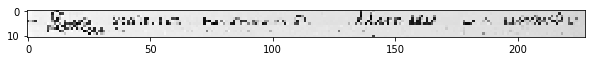

In [102]:
# warp image
offset_min = -5
offset_max = 5
tst_curve1 = np.array(tst_curve)

res_img = np.zeros(shape=(offset_max - offset_min + 1, tst_curve1.shape[1]))

for i in range(offset_min, offset_max + 1):
    res_img[i,:] = src3[tst_curve1[1,:]+i+offset_min+3, tst_curve1[0,:]]

plt.figure(figsize=(10,10))
plt.imshow(res_img, cmap='gray')

Wall time: 15 ms


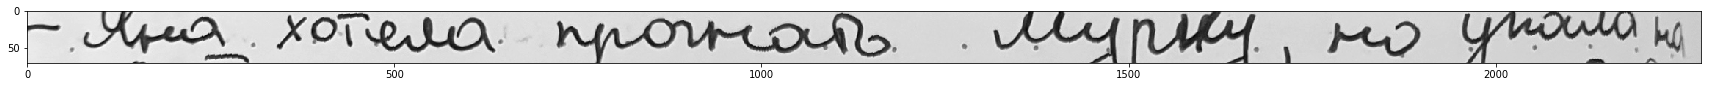

In [103]:
%%time
# warp src image
offset_min = -3 * sz_factor
offset_max = 4 * sz_factor
tst_curve1 = np.array(tst_curve)
tst_curve2_j = np.linspace(np.min(tst_curve1[0,:]), np.max(tst_curve1[0,:]), 30)
tst_curve2_i = np.interp(tst_curve2_j, tst_curve1[0,:], tst_curve1[1,:])
tst_curve2 = np.array([tst_curve2_j, tst_curve2_i])

res_img = np.zeros(shape=(offset_max - offset_min + 1, tst_curve1.shape[1] * sz_factor))
interp_j = np.linspace(np.min(tst_curve2[0,:]), np.max(tst_curve2[0,:]), tst_curve1.shape[1] * sz_factor)
actual_j = np.arange(np.min(tst_curve2[0,:])*sz_factor, (np.max(tst_curve2[0,:])+1)*sz_factor).astype(int)
interp_i = np.round(np.interp(interp_j, tst_curve2[0,:], (tst_curve2[1,:]+3)*sz_factor) + offset_min).astype(int)
tmp = []
for i in range(offset_max - offset_min + 1):
    res_img[i,:] = srcr[interp_i+i, actual_j]

plt.figure(figsize=(30,30))
plt.imshow(res_img, cmap='gray')

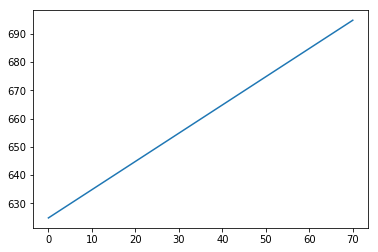

In [82]:
plt.plot(tmp)

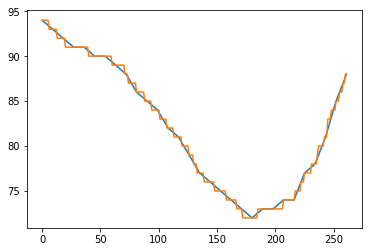

In [97]:
plt.plot(tst_curve2_j, tst_curve2_i)
plt.plot(tst_curve1[0,:], tst_curve1[1,:])

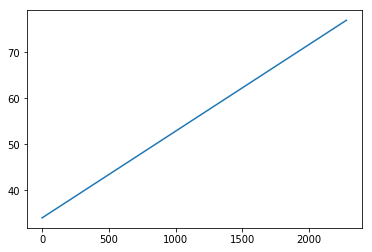

In [51]:
plt.plot(interp_j)

In [76]:
np.min(tst_curve2[0,:])*sz_factor, (np.max(tst_curve2[0,:])+1)*sz_factor

(340.0, 2620.0)

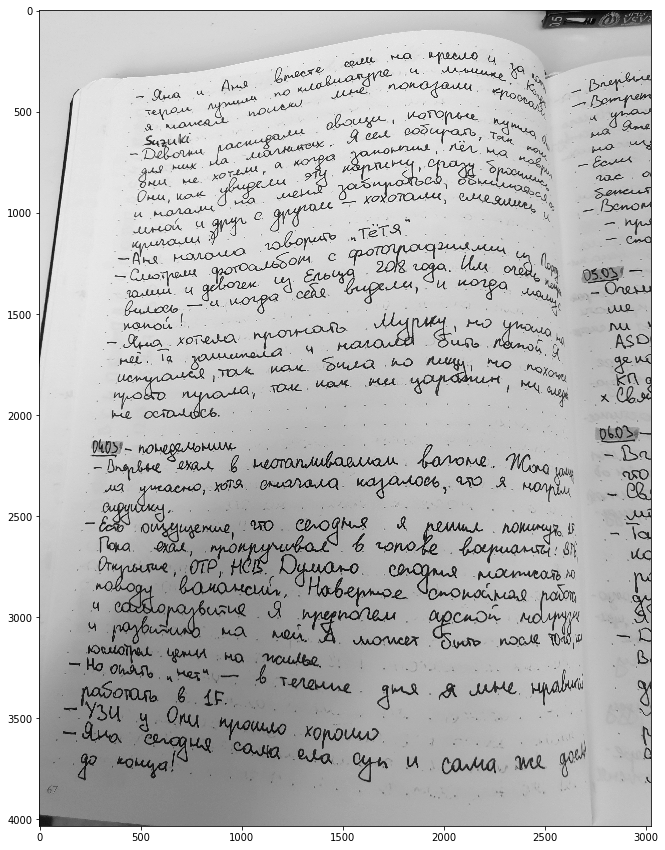

In [80]:
plt.figure(figsize=(15,15))
plt.imshow(srcr, cmap='gray')